In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import geopandas as gpd
import pandas as pd

In [17]:
COUNTY = '037'
AREA = 'Davidson'

In [27]:
# input Hamilton county geo file
county_cbg = gpd.read_file('../data/Tennessee Census Block Groups/tl_2020_47_bg.shp')
county_cbg = county_cbg[county_cbg.COUNTYFP==COUNTY]
county_cbg = county_cbg.to_crs('epsg:4326')

In [7]:
minx, miny, maxx, maxy = county_cbg.geometry.total_bounds

In [8]:
minx, miny, maxx, maxy

(-87.054705, 35.967785, -86.51558899999999, 36.405496)

In [9]:
#finding all buildings
tags = {'building': True}
buildings = ox.geometries_from_bbox(miny, maxy, maxx, minx, tags)
# buildings = ox.geometries_from_bbox(34.854382885097905, 35.935532323321, -84.19759521484375, -85.553161621093756, tags)

c:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
c:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [11]:
#aggregating all residential tags
pd.set_option('display.max_columns', None)
res_build = buildings[(buildings.building == 'residential') | (buildings.building == 'bungalow') | (buildings.building == 'cabin') | (buildings.building == 'dormitory') | (buildings.building == 'hotel') | (buildings.building == 'house') | (buildings.building == 'semidetached_house') | (buildings.building == 'barracks') | (buildings.building == 'farm') | (buildings.building == 'ger') | (buildings.building == 'houseboat') | (buildings.building == 'static_caravan') | (buildings.building == 'terrace')].reset_index()[['osmid', 'geometry', 'nodes', 'building', 'name', 'source']].sjoin(county_cbg)
res_build.geometry = res_build.geometry.apply(lambda x: x.centroid if x.geom_type =='Polygon' else x)

In [25]:
#saving residential buildings
res_build.to_csv(f'../data/county_residential_buildings.csv', index=False)

In [19]:
pd.set_option('display.max_columns', None)

#work tags

com_build = buildings[(buildings.building == 'commercial') | (buildings.building == 'industrial') | (buildings.building == 'kiosk') | (buildings.building == 'office') | (buildings.building == 'retail') | (buildings.building == 'supermarket') | (buildings.building == 'warehouse')].reset_index()[['osmid', 'geometry', 'nodes', 'building', 'name', 'source']].sjoin(ham_cbg)
civ_build = buildings[(buildings.building == 'bakehouse') | (buildings.building == 'civic') | (buildings.building == 'college') | (buildings.building == 'fire_station') | (buildings.building == 'government') | (buildings.building == 'hospital') | (buildings.building == 'kindergarten') | (buildings.building == 'public') | (buildings.building == 'school') | (buildings.building == 'train_station') | (buildings.building == 'transportation') | (buildings.building == 'university')].reset_index()[['osmid', 'geometry', 'nodes', 'building', 'name', 'source']].sjoin(ham_cbg)

com_build.geometry = com_build.geometry.apply(lambda x: x.centroid if x.geom_type =='Polygon' else x)
civ_build.geometry = civ_build.geometry.apply(lambda x: x.centroid if x.geom_type =='Polygon' else x)

In [20]:
def func(row):
    str(Point(gpd.points_from_xy(row.INTPTLAT, row.INTPTLON)[0]))

In [21]:
#converting the default internal point of each cbg to a shapely Point
res_build['intpt'] = res_build[['INTPTLAT', 'INTPTLON']].apply(lambda x: func, axis=1)

## adding safegraph poi locations

In [39]:
# add safegraph extracted data
sg = gpd.read_file('path to safegraph file') # path removed due to privacy concerns
sg.longitude = sg.longitude.astype(float)
sg.latitude = sg.latitude.astype(float)
geom = [Point(xy) for xy in zip(sg.longitude, sg.latitude)]
sg = gpd.GeoDataFrame(sg, geometry = geom, crs='epsg:4326')

In [23]:
#adding in safegraph POI locations to OSM work locations

# t1 = (sg[['poi_cbg', 'geometry']].rename({'poi_cbg':'GEOID'},axis=1).append(com_build[['GEOID', 'geometry']]).append(civ_build[['GEOID', 'geometry']]))
t1 = com_build[['GEOID', 'geometry']].append(civ_build[['GEOID', 'geometry']])
t1.GEOID = t1.GEOID.astype(str).apply(lambda x: x.split('.')[0])

# saving work buildings to file 
t1.to_csv(f'../data/county_work_loc_poi_com_civ.csv', index=False)

In [30]:
t1.head()

,GEOID,geometry
0,470370175001,POINT (-86.74620 36.10949)
593,470370175001,POINT (-86.74506 36.10895)
974,470370175001,POINT (-86.74671 36.11054)
975,470370175001,POINT (-86.74664 36.11078)
1,470370193001,POINT (-86.76540 36.17265)


<AxesSubplot:>

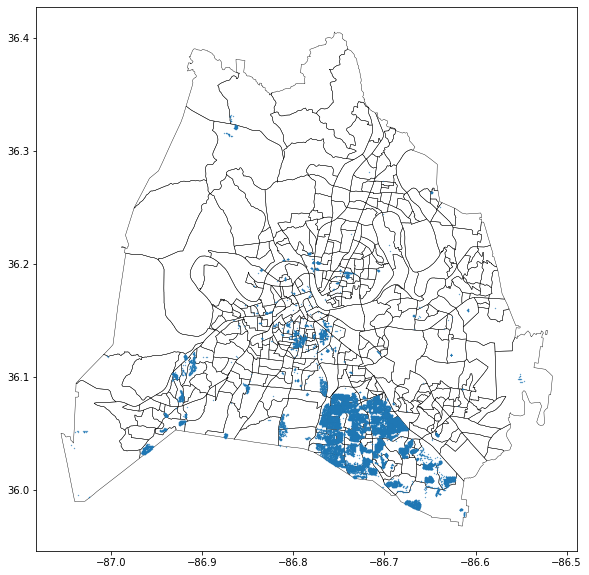

In [32]:
ax=county_cbg.plot(figsize=(10, 10), color='None', edgecolor="black", linewidth=0.4)
res_build.plot(figsize=(10, 10), ax=ax, markersize=0.1)